In [1]:
%pylab inline --no-import-all

from ctypes import c_float
import sys

# import numpy as np
from astropy.io import fits
from scipy.interpolate import RegularGridInterpolator


from ROOT import gSystem, TFile, TCanvas, TGraphAsymmErrors, TH1D, TH2D, TGraphAsymmErrors, TProfile
import uproot
import matplotlib.pyplot as plt

from root_numpy import hist2array

# from ROOT import VARootIO, VAEffectiveAreaManager, VAEASimpleParameterData
# if gSystem.Load("$EVNDISPSYS/lib/libVAnaSum.so"):
#     print("Problem loading EventDisplay libraries - please check this before proceeding")
    
# from ROOT import VInstrumentResponseFunctionData

Populating the interactive namespace from numpy and matplotlib
Welcome to JupyROOT 6.14/04


Here most of the functions used to read the effective area file and convert ROOT histograms to numpy arrays.

It's a complete mess, but if you want, I can try to document it a bit (more).

In [2]:
def remove_duplicities(array, atol):
    i = 0
    while(i < len(array)-1):
        i += 1
        if np.isclose(array[i-1], array[i], atol=atol):
            array = np.delete(array,i-1)
            i -= 1
    return array

def graph_to_array_y(graph):
    y = [g for g in graph.GetY()]
    return y

def graph_to_array_x(graph):
    x = [g for g in graph.GetX()]
    return x

def bin_edges_to_centers(axis):
    # This function assumes bins of equal width
    bin_size = axis[1]-axis[0]
    return np.delete(axis + bin_size/2., len(axis)-1)

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def extract_irf(filename, irf_name, coord_tuple=False, return_irf_axes=False): 
    # Get both the ROOT effective area TTree and the uproot one (much faster)
    effAreaFile = TFile.Open(filename)
    effAreaTree = effAreaFile.Get("fEffArea")
    fast_effArea = uproot.open(filename)['fEffArea']

    # Load parameters from each TTree on arrays with uproot (super fast)
    all_zds = fast_effArea.array('ze')
    all_azs = fast_effArea.array('az')
    all_azMins = fast_effArea.array('azMin')
    all_azMaxs = fast_effArea.array('azMax')
    all_Woffs = fast_effArea.array('Woff')
    all_pedvars = fast_effArea.array('pedvar')
    all_indexs = fast_effArea.array('index')
    all_nbins =  fast_effArea.array('nbins')
    all_rec_nbins =  fast_effArea.array('Rec_nbins')
    
    # If no coord_tuple is provided, extract the IRF over all dimensions
    azs = indexs = pedvars = zds = woffs = []
    if not coord_tuple:
        zds, zes_counts = np.unique(np.round(fast_effArea.array('ze'), decimals=2), return_counts=True)
        azs = np.unique(fast_effArea.array('az'))
        woffs, Woffs_counts = np.unique(np.round(fast_effArea.array('Woff'), decimals=2), return_counts=True)
        pedvars, pedvars_counts = np.unique(np.round(fast_effArea.array('pedvar'), decimals=2), return_counts=True)
        indexs, indexs_counts = np.unique(np.round(fast_effArea.array('index'), decimals=2), return_counts=True)
        # IMPORTANT: Remove duplicities (shouldn't be the case, but the values are not stored properly...)
        # We remove the duplicities from the zenith and pedestal values arrays:
        zds = remove_duplicities(zds, 2.0)
        pedvars = remove_duplicities(pedvars, 0.21)
        if len(all_zds) != len(zds) * len(azs) * len(woffs) * len(pedvars) * len(indexs):
            raise ValueError("Wrong dimensions extracted from IRF cube." +  
                             "Probably due to the rounding applied to the IRF coordinates.")
    # If a specific coord_tuple is provided, only extract the IRFs wihin that range of dimensions
    else:
        if len(coord_tuple) != 5:
            raise ValueError("coord_tuple needs to contain 5 dimensions, in this order: az, index, pedvar, zd and woff")
        else:
            # Get the coordinates to sample:
            azs = coord_tuple[0]
            indexs = coord_tuple[1]
            pedvars = coord_tuple[2]
            zds = coord_tuple[3]
            woffs = coord_tuple[4]
    
    print(azs, indexs, pedvars, zds, woffs)
    
    # For performance, deactivate all branches except the ones needed:
    # Also get the entry with max bins to define the binning in energy
    effAreaTree.SetBranchStatus("*",0) 
    if irf_name == 'eff':
        effAreaTree.SetBranchStatus("e0",1)
        effAreaTree.SetBranchStatus("eff",1)
        entry_with_max_bins = find_nearest(all_nbins, all_nbins.max())
    elif irf_name == 'Rec_eff':
        effAreaTree.SetBranchStatus("Rec_e0",1)
        effAreaTree.SetBranchStatus("Rec_eff",1)
        entry_with_max_bins = find_nearest(all_rec_nbins, all_rec_nbins.max())
    elif irf_name == 'gEffAreaNoTh2MC':
        effAreaTree.SetBranchStatus("gEffAreaNoTh2MC",1)
        entry_with_max_bins = 0
    elif irf_name == 'gEffAreaNoTh2Rec':
        effAreaTree.SetBranchStatus("gEffAreaNoTh2Rec",1)
        entry_with_max_bins = 0
    elif irf_name == 'hEsysMCRelative2D':
        effAreaTree.SetBranchStatus("hEsysMCRelative2D",1)
        entry_with_max_bins = 0
    elif irf_name == 'hAngularDiff_2D':
        effAreaTree.SetBranchStatus("hAngularDiff_2D",1)
        entry_with_max_bins = 0
    else:
        raise Exception("WrongIrfName")
    # Now we know which entry we need to get in order to have a sample IRF
#     sample_irf = sample_energies = []
    for i, entry in enumerate(effAreaTree):
        if i == entry_with_max_bins:
            if irf_name == 'eff':
                sample_irf = [j for j in entry.eff]
                sample_energies = [j for j in entry.e0]
            elif irf_name == 'Rec_eff':
                sample_irf = [j for j in entry.Rec_eff]
                sample_energies = [j for j in entry.Rec_e0]
            elif irf_name == 'gEffAreaNoTh2MC':
                sample_irf = graph_to_array_y(entry.gEffAreaNoTh2MC)
                sample_energies = graph_to_array_x(entry.gEffAreaNoTh2MC)
            elif irf_name == 'gEffAreaNoTh2Rec':
                sample_irf = graph_to_array_y(entry.gEffAreaNoTh2Rec)
                sample_energies = graph_to_array_x(entry.gEffAreaNoTh2Rec)
            elif irf_name == 'hEsysMCRelative2D':
                # Migration vs energy bias and true energy
                sample_irf, axes = hist2array(entry.hEsysMCRelative2D, return_edges=True)
                # Bin edges (one more entry than migra!) for the true energy and 
                # energy bias (Erec/Etrue)
                irf_dimension_1 = bin_edges_to_centers(axes[0])
                irf_dimension_2 = bin_edges_to_centers(axes[1])
            elif irf_name == 'hEsysMCRelative2DNoDirectionCut':
                # Migration vs energy bias and true energy, without direction cut
                sample_irf, axes = hist2array(entry.hEsysMCRelative2DNoDirectionCut, return_edges=True)
                # Bin edges (one more entry than migra!) for the true energy and 
                # energy bias (Erec/Etrue)
                irf_dimension_1 = bin_edges_to_centers(axes[0])
                irf_dimension_2 = bin_edges_to_centers(axes[1])
            elif irf_name == 'hAngularDiff_2D':
                # PSF vs true energy:
                sample_irf, axes = hist2array(entry.hAngularDiff_2D, return_edges=True)
                # Bin edges (one more entry than migra!) for the true energy and 
                # energy bias (Erec/Etrue)
                irf_dimension_1 = bin_edges_to_centers(axes[0])
                irf_dimension_2 = bin_edges_to_centers(axes[1])
                print(irf_dimension_1, irf_dimension_2)
                print("Length: ", len(irf_dimension_1), len(irf_dimension_2))
            else:
                raise Exception("WrongIrfName")
        if i > entry_with_max_bins:
            break
    # Create data container, filled with zeros, containing the required dimensions to store
    # the IRF for a given coord_tuple. Separated between 1 and 2 dimensions:
    if (irf_name == "hEsysMCRelative2D" or irf_name == "hEsysMCRelative2DNoDirectionCut" or 
            irf_name == "hAngularDiff_2D"):
        data = np.zeros((len(irf_dimension_1), len(irf_dimension_2), len(azs), len(indexs), len(pedvars), len(zds), len(woffs)))
    else:
        data = np.zeros((len(sample_irf), len(azs), len(indexs), len(pedvars), len(zds), len(woffs)))
    # Iterate over all IRFs within the file. If the entry i is close to the coordinates within
    # the coord_tuple, then store.
    for i, entry in enumerate(effAreaTree):
        if i%5000 == 0:
            print("{}/{}".format(i, len(all_zds)))
#         if i == 3239:
#             print([j for j in entry.Rec_e0])
        # Parameters within the effective area files show some fluctuation, therefore 
        # we need to use the "isclose".
        if (np.isclose(azs, all_azs[i], atol=0.01).any() and
                np.isclose(indexs, all_indexs[i], atol=0.01).any() and
                np.isclose(pedvars, all_pedvars[i], atol=0.21).any() and
                np.isclose(zds, all_zds[i], atol=2.1).any() and
                np.isclose(woffs, all_Woffs[i], atol=0.05).any()):
            if irf_name == 'eff':
                irf = [j for j in entry.eff]
                energies = [j for j in entry.e0]
            elif irf_name == 'Rec_eff':
                irf = [j for j in entry.Rec_eff]
                energies = [j for j in entry.Rec_e0]
            elif irf_name == 'gEffAreaNoTh2MC':
                irf = graph_to_array_y(entry.gEffAreaNoTh2MC)
                energies = graph_to_array_x(entry.gEffAreaNoTh2MC)
            elif irf_name == 'gEffAreaNoTh2Rec':
                irf = graph_to_array_y(entry.gEffAreaNoTh2Rec)
                energies = graph_to_array_x(entry.gEffAreaNoTh2Rec)
            elif irf_name == 'hEsysMCRelative2D':
                irf = hist2array(entry.hEsysMCRelative2D)
            elif irf_name == 'hEsysMCRelative2DNoDirectionCut':
                irf = hist2array(entry.hEsysMCRelative2DNoDirectionCut)
            elif irf_name == 'hAngularDiff_2D':
                irf = hist2array(entry.hAngularDiff_2D)
            else:
                raise Exception("WrongIrfName")
            # We separate now 1D and 2D irfs:
            # 2D IRFs:
            if (irf_name == "hEsysMCRelative2D" or irf_name == "hEsysMCRelative2DNoDirectionCut" or 
                    irf_name == "hAngularDiff_2D"):
                if np.shape(irf) == np.shape(sample_irf):
                    try:
                        data[:,:, find_nearest(azs, all_azs[i]), find_nearest(indexs, all_indexs[i]), find_nearest(pedvars, all_pedvars[i]), 
                             find_nearest(zds, all_zds[i]), find_nearest(woffs, all_Woffs[i])] = irf
                    except:
                        print("Unexpected error:", sys.exc_info()[0])
                        print("Entry number ", i)
                        raise
                else:
                    print("2D IRFs of variable size...")
                    raise
            else:
                # 1D IRFs:
                # In case the extracted IRF has less bins than the "sample" one, pad it with zeros:
                if len(irf) < len(sample_irf):
                    new_irf = np.zeros(len(sample_energies))
                    for j, ener in enumerate(energies):
                        new_irf[find_nearest(sample_energies, ener)] = irf[j]
                    irf = new_irf
                try:
                    data[:, find_nearest(azs, all_azs[i]), find_nearest(indexs, all_indexs[i]), find_nearest(pedvars, all_pedvars[i]), 
                         find_nearest(zds, all_zds[i]), find_nearest(woffs, all_Woffs[i])] = irf
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    print("Entry number ", i)
                    print(energies, irf)
                    raise 
    if return_irf_axes:
        if (irf_name == "hEsysMCRelative2D" or irf_name == "hEsysMCRelative2DNoDirectionCut" or 
                irf_name == "hAngularDiff_2D"):
            return data, [np.array(irf_dimension_1), np.array(irf_dimension_2), azs, indexs, pedvars, zds, woffs]
        else:
            return data, [np.array(sample_energies), azs, indexs, pedvars, zds, woffs]
    else:
        return data


def duplicate_dimension(data, axis):
    # This function duplicates a single axis, assuming it's length is 1.
    current_shape = np.shape(data)
    corrected_shape = [2 if i == axis else k for i, k in enumerate(current_shape)]
    print(current_shape, corrected_shape)
    new_data = np.zeros(corrected_shape)
    sl = slice(None, None, None)
    new_data[[0 if i == axis else sl for i, k in enumerate(current_shape)]] = \
        data[[0 if i == axis else sl for i, k in enumerate(current_shape)]]
    new_data[[1 if i == axis else sl for i, k in enumerate(current_shape)]] = \
        data[[0 if i == axis else sl for i, k in enumerate(current_shape)]]
    return new_data


def duplicate_dimensions(data):
    # This function duplicates all axes, one by one, when their size is 1.
    new_data = data
    current_shape = np.shape(new_data)
    for i, dim in enumerate(current_shape):
        if (dim == 1):
            new_data = duplicate_dimension(new_data, i)
    return new_data

This is the current class to be used for the IRF interpolator. We probably need to add more checks, for instance that the coordinate the user tries to interpolate is within the coordinate "space" within the effective area file.

The current IRF interpolator has this shape:
* Inputs:
    * Effective area file, containing all IRFs in the form $A_{i,j,k,l,m}$ where A can be any IRF and $i..m$ the dimensions within the file. Each IRF within the file has a coordinate $X = [x_i, x_j, x_k, x_l, x_m]$, a point in the 5D "hyper cube" of IRFs, to be used in the interpolation.

The dimensions are (used in this order):
        * Azimuth
        * Power-law index
        * Pedestal variance
        * Zenith
        * Camera offset (Woff)
* The steps performed are:
    * First read the IRF file: 
        * Load range of all available dimensions $[D_{min}, ..., D_{max}]_{i,j,k,l,m}$ within the file (points corresponding to each IRF)
        * Load a 5D cube of a given IRF, as a function of all dimensions 
    * TO BE IMPLEMENTED: Check if $X \in D$. If yes, continue. If not... New IRFs need to be computed.
    * Interpolate the IRF
        * Input: the 5D coordinate to be interpolated
        * Returns: the content of the irf (can be 1D or 2D) and the axes (currently just the values, should add more information, probably in the form of a dictionary)

In [3]:
class IrfInterpolator:
    def __init__(self, filename):
        self.implemented_irf_names_1d = ['eff', 'Rec_eff', 'gEffAreaNoTh2MC', 'gEffAreaNoTh2Rec']
        self.implemented_irf_names_2d = ['hEsysMCRelative2D', 'hEsysMCRelative2DNoDirectionCut', 'hAngularDiff_2D']
        self.irf_name = ""
        import os.path
        if os.path.isfile(filename):
            self.filename = filename
        else:
            raise FileNotFoundError

    def set_irf(self, irf_name):
        if irf_name in self.implemented_irf_names_1d or irf_name in self.implemented_irf_names_2d:
            self.irf_name = irf_name
            self.__load_irf()
        else:
            print("The irf you entered: {}  is either wrong or not implemented.".format(irf_name))
            raise WrongIrf

    def __load_irf(self):
        irf_data, irf_axes = extract_irf(self.filename, self.irf_name, return_irf_axes=True)
        # This is an important technical step: the regular grid interpolator does not accept 
        # interpolating on a dimension with size = 1.
        # Make sure that there are no size 1 dimensions. Do the same with the axes:
        irf_data = duplicate_dimensions(irf_data)
        # Also the coordinates of the axes need to be in increasing order.
        for i, axis in enumerate(irf_axes):
            if len(axis) == 1:
                irf_axes[i] = np.concatenate((axis.flatten(), axis.flatten() + 0.01), axis=None)
        self.irf_data = irf_data
        self.irf_axes = irf_axes
        self.interpolator = RegularGridInterpolator(self.irf_axes, self.irf_data)

    def interpolate(self, coordinate):
        # The interpolation is slightly different for 1D or 2D IRFs. We do both cases separated:
        if self.irf_name in self.implemented_irf_names_2d:
            # In this case, the interpolator needs to interpolate over 2 dimensions:
            xx, yy = np.meshgrid(self.irf_axes[0], self.irf_axes[1])
            interpolated_irf = self.interpolator((xx, yy, coordinate[0], coordinate[1], coordinate[2],
                                                  coordinate[3], coordinate[4]))
            return interpolated_irf, [self.irf_axes[0], self.irf_axes[1]]
        elif self.irf_name in self.implemented_irf_names_1d:
            # In this case, the interpolator needs to interpolate only over 1 dimension (true energy):
            interpolated_irf = self.interpolator((self.irf_axes[0], coordinate[0], coordinate[1],
                                                  coordinate[2], coordinate[3], coordinate[4]))
            return interpolated_irf, [self.irf_axes[0]]
        else:
            print("The interpolation of the irf you entered: {}  is either wrong or not implemented.".format(self.irf_name))
            raise WrongIrf

Example of use: These 2 steps should ideally be done just once, and then perform a serie of interpolations of this given IRF, taking into account that the slowest step is to load the whole 5D cube of IRFs.

In [4]:
irf_generator = IrfInterpolator('../../../eventDisplay/gernot_effarea_test_direction_full_stats.root')
irf_generator.set_irf('eff')

[0 1 2 3 4 5 6 7 8] [ 1.5         1.60000002  1.70000005  1.79999995  1.89999998  2.          2.0999999
  2.20000005  2.29999995  2.4000001   2.5         2.5999999   2.70000005
  2.79999995  2.9000001   3.          3.0999999   3.20000005  3.29999995
  3.4000001   3.5         3.5999999   3.70000005  3.79999995  3.9000001   4.
  4.0999999   4.19999981  4.30000019  4.4000001   4.5         4.5999999
  4.69999981  4.80000019  4.9000001   5.          5.0999999   5.19999981
  5.30000019  5.4000001 ] [ 7.61000013] [ 20.] [ 0.5]
0/360
(38, 9, 40, 1, 1, 1) [38, 9, 40, 2, 1, 1]
(38, 9, 40, 2, 1, 1) [38, 9, 40, 2, 2, 1]
(38, 9, 40, 2, 2, 1) [38, 9, 40, 2, 2, 2]


Warning in <TClass::Init>: no dictionary for class VMonteCarloRunHeader is available
Warning in <TClass::Init>: no dictionary for class VInstrumentResponseFunctionData is available
Warning in <TClass::Init>: no dictionary for class VHistogramUtilities is available
Warning in <TClass::Init>: no dictionary for class VGammaHadronCuts is available
Warning in <TClass::Init>: no dictionary for class VAnalysisUtilities is available
Warning in <TClass::Init>: no dictionary for class VTMVAEvaluatorResults is available
Warning in <TClass::Init>: no dictionary for class VInstrumentResponseFunctionRunParameter is available


Once this step is done, the interpolation is very fast. So for example, let's draw some effective areas as a function of zenith:

/home/thassan/Paquetes/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


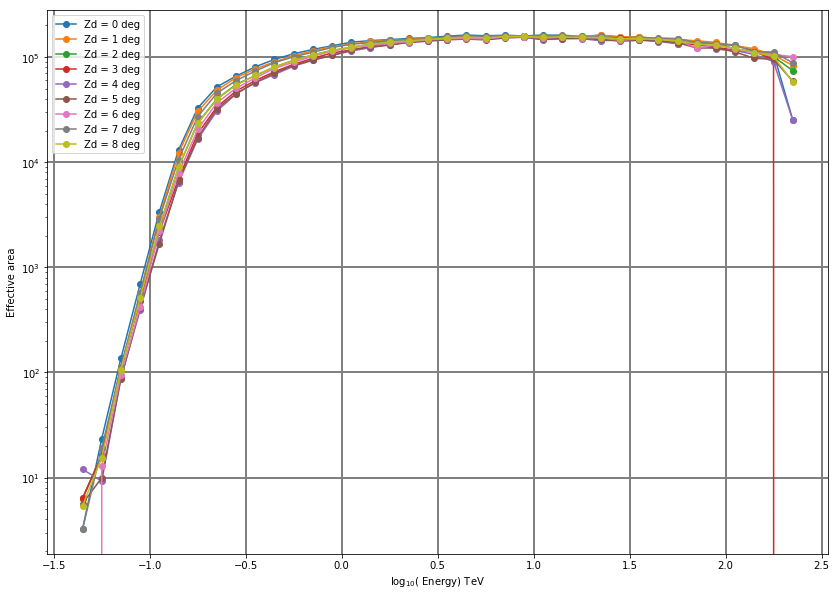

In [12]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111)
for azimuth in np.arange(9):
    irf, axis = irf_generator.interpolate([azimuth, 2.5999999, 7.611, 20., 0.5])
    ax.plot(axis[0], irf, marker='o', label='Azimuth bin {} deg'.format(azimuth))
ax.grid(color='gray', linestyle='-', linewidth=2)
ax.set_xlabel('log$_{10}$( Energy) TeV')
ax.set_yscale("log", nonposy='clip')
ax.set_ylabel('Effective area')
ax.legend()
fig.show()

As another example, this time a 2D IRF such as the energy bias vs true energy, we do the same:

In [13]:
# irf_generator = Irf_interpolator('gernot_effarea_test_direction_full_stats.root')
irf_generator.set_irf('hEsysMCRelative2D')

[0 1 2 3 4 5 6 7 8] [ 1.5         1.60000002  1.70000005  1.79999995  1.89999998  2.          2.0999999
  2.20000005  2.29999995  2.4000001   2.5         2.5999999   2.70000005
  2.79999995  2.9000001   3.          3.0999999   3.20000005  3.29999995
  3.4000001   3.5         3.5999999   3.70000005  3.79999995  3.9000001   4.
  4.0999999   4.19999981  4.30000019  4.4000001   4.5         4.5999999
  4.69999981  4.80000019  4.9000001   5.          5.0999999   5.19999981
  5.30000019  5.4000001 ] [ 7.61000013] [ 20.] [ 0.5]
0/360
(60, 300, 9, 40, 1, 1, 1) [60, 300, 9, 40, 2, 1, 1]
(60, 300, 9, 40, 2, 1, 1) [60, 300, 9, 40, 2, 2, 1]
(60, 300, 9, 40, 2, 2, 1) [60, 300, 9, 40, 2, 2, 2]


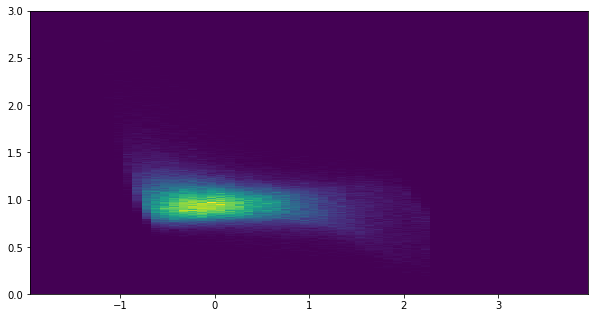

In [14]:
irf, axis = irf_generator.interpolate([0, 2.5999999, 7.611, 20.0, 0.5])
fig = plt.figure(figsize=(10,15))
plt.imshow(np.flip(irf, axis=0), vmin=irf.min(), vmax=irf.max(),
           extent=[axis[0].min(), axis[0].max(), axis[1].min(), axis[1].max()])

You can always access the values that are contained in the Effective area file (and it's coordinates) after you load them with the 'irf_generator.set_irf()' function:

In [16]:
print("Loaded IRF: ", irf_generator.irf_name)
print("Shape of the IRF hypercube: ", np.shape(irf_generator.irf_data))
print(irf_generator.irf_axes)

Loaded IRF:  hEsysMCRelative2D
Shape of the IRF hypercube:  (60, 300, 9, 40, 2, 2, 2)
[array([-1.95, -1.85, -1.75, -1.65, -1.55, -1.45, -1.35, -1.25, -1.15,
       -1.05, -0.95, -0.85, -0.75, -0.65, -0.55, -0.45, -0.35, -0.25,
       -0.15, -0.05,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,
        0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,  1.55,
        1.65,  1.75,  1.85,  1.95,  2.05,  2.15,  2.25,  2.35,  2.45,
        2.55,  2.65,  2.75,  2.85,  2.95,  3.05,  3.15,  3.25,  3.35,
        3.45,  3.55,  3.65,  3.75,  3.85,  3.95]), array([ 0.005,  0.015,  0.025,  0.035,  0.045,  0.055,  0.065,  0.075,
        0.085,  0.095,  0.105,  0.115,  0.125,  0.135,  0.145,  0.155,
        0.165,  0.175,  0.185,  0.195,  0.205,  0.215,  0.225,  0.235,
        0.245,  0.255,  0.265,  0.275,  0.285,  0.295,  0.305,  0.315,
        0.325,  0.335,  0.345,  0.355,  0.365,  0.375,  0.385,  0.395,
        0.405,  0.415,  0.425,  0.435,  0.445,  0.455,  0.465,  0.475,
        0.485,  